## Descripcion:
Modulador GFSK solo para simulacion en python

Incluye:
 - Generacion de Señal de datos aleatoria
 - Modulacion FSK

Version: 1

## Importamos librerias

In [ ]:
!pip install scikit-dsp-comm
!pip install scikit-commpy

In [ ]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
import commpy
#%matplotlib notebook

## Funciones

In [ ]:
# Funcion para diseñar un filtro coseno realzado
# Fuente: https://scikit-dsp-comm.readthedocs.io/en/latest/_modules/sk_dsp_comm/sigsys.html
# Parametros:
#    Ns    : int   - Numero de muestras por bit
#    alpha : float - Roll off factor (Valid values are [0, 1]).
#    M     : int   - Cantidad de simbolos que abarca el filtro.
def rc_imp(Ns,alpha,M=6):
    n = np.arange(-int(Ns*M/2),int(Ns*M/2))
    b = np.zeros(len(n))
    print(len(n))
    a = alpha
    Ns = 1.0*Ns
    for i in range(len(n)):
        if (1 - 4*(a*n[i]/Ns)**2) == 0:
            b[i] = (np.pi/4)*np.sinc(1/(2.*a))
        else:
            b[i] = np.sinc(n[i]/Ns)*np.cos(np.pi*a*n[i]/Ns)/(1 - 4*(a*n[i]/Ns)**2)
    return b

In [ ]:
# Funcion para diseñar un filtro gauseano
# Fuente: https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
# Parametros
#    Ns    : int   - Numero de muestras por bit
#    B     : float - Ancho de banda.
#    M     : int   - Cantidad de simbolos que abarca el filtro.
def gaussianfilter(Ns, B, M=6):
    n = np.arange(-int(Ns*M/2),int(Ns*M/2))/Ns
    #b = (np.sqrt(np.pi)/alpha)*np.exp(-((np.pi*n/alpha)*(np.pi*n/alpha)))
    #b = (np.sqrt(alpha/np.pi)*np.exp(-(alpha)*(n)**2))*Ns
    K=1
    b = K*np.sqrt(2*np.pi/np.log(2))*B*np.exp((-2*((B*np.pi)**2)*(n**2))/(np.log(2)))
    return b

In [ ]:
# Funcion para generar la señal a transmitir.
# Parametros:
# - _TxData -> Datos binarios a transmitir
# - _Ns     -> Numero de muestras por bit
# - _alpha  -> Factor Alpha, no valido para filtro tipo 'rect' (se ignora)
# - _tipo   -> Tipo de filtrado
# - _M      -> Largo del filtro, es en funcion del largo de cada bit
def Generar_señal(_TxData, _Ns, _beta, _tipo, _M=6):
    N_bits = len(_TxData)
    n_zeros = np.zeros((N_bits,int(_Ns)-1))
    x = np.hstack((2*_TxData.reshape(N_bits,1)-1,n_zeros))
    x = x.flatten()
    
    # Interpolado / NRZ 
    b = np.ones(int(_Ns))
    x = signal.lfilter(b,1,x)
    
    if (_tipo.upper() == 'NRZ'):
        # NRZ
        pass
        
    elif (_tipo.upper() == 'RC'):
        # RC
        b = rc_imp(_Ns,_beta,_M)
        x = signal.lfilter(b,1,x)
        
    elif (_tipo.upper() == 'GAUSS'):
        # GAUSS        
        b = gaussianfilter(_Ns,_beta,_M)
        x = signal.lfilter(b,1,x)
        x = x/max(x)
    
    return x, b

## Generamos la señal a transmitir

In [ ]:
# Parametros
NroBits = 1000     # Numero de bits a transmitir
fs = 10000         # Frecuencia de muestreo [Hz]
ts = 1/fs          # Periodo de muestreo [sec]
Tbit = 0.01        # Tiempo del bit [sec]
Ns = int(fs*Tbit)  # Muestras por bit de dato
Fc = 1000          # [Hz] Frecuencia de portadora
DeltaF = 50

# Datos random
TxData = np.random.randint(2,size=NroBits)

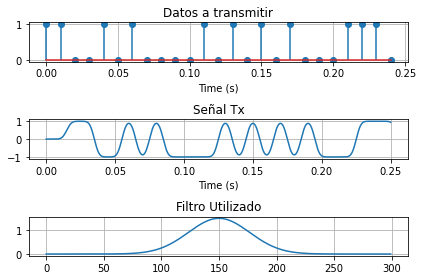

In [ ]:
# Parametros para la modulacion
Tipo = 'gauss'   # Tipo de filtro a utilizar [nrz, rc, gauss]
Beta = 0.5       # Beta para el filtro gauseano
M=3

# Generacion de la FSK
Señal_Tx, Pulse_shape = Generar_señal(TxData, Ns, _beta=Beta, _tipo=Tipo, _M=M)
t = np.arange(len(Señal_Tx))

# Plot
plt.figure()
plt.subplot(311)
plt.stem(ts*t[0:25]/Tbit,TxData[0:25], use_line_collection=True)
plt.title("Datos a transmitir")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(312)
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.title("Señal Tx")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(313)
plt.plot(Pulse_shape)
plt.title("Filtro Utilizado")
plt.grid()
plt.tight_layout()
plt.show()

## Diagrama de ojo

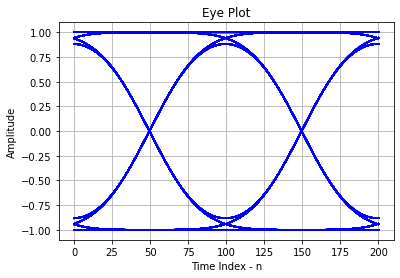

In [ ]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(Señal_Tx[Ns*5:],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

In [ ]:
samples = Señal_Tx[Ns*5::Ns]
minimo = min(samples[samples>0])
maximo = max(samples[samples<0])
aux = min(np.abs(minimo),np.abs(maximo))
ISIS = aux/1
print(ISIS)

0.8815434239313081


## Generamos la señal FSK

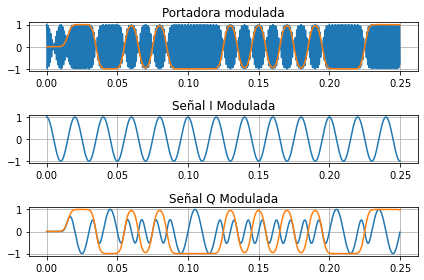

In [ ]:
# Señales Modulantes
Cos_DeltaF = np.cos(2*np.pi*(DeltaF)*(t*ts))
Sin_DeltaF = np.sin(2*np.pi*(DeltaF)*(t*ts))


# Portadoras
OL_Cos = np.cos(2*np.pi*(Fc)*(t*ts))
OL_Sin = np.sin(2*np.pi*(Fc)*(t*ts))


# Modulacion de las portadoras
#st_uno  = OL_Cos*Cos_DeltaF - OL_Sin*Sin_DeltaF  # Señal para los bits 1
#st_cero = OL_Cos*Cos_DeltaF + OL_Sin*Sin_DeltaF  # Señal para los bits 0
# Suma
#st = st_uno*((Señal_Tx+1)/2) + st_cero *((Señal_Tx-1)/2)*(-1)

I = Cos_DeltaF
Q = -1 * Sin_DeltaF*(Señal_Tx) # Señal_Tx -> señal de datos, toma valores -1 y 1
st  = OL_Cos*I + OL_Sin*Q


plt.figure()
plt.subplot(311)
plt.plot(ts*t[0:Ns*25], st[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Portadora modulada")
plt.subplot(312)
plt.plot(ts*t[0:Ns*25], I[0:Ns*25])
plt.grid()
plt.title("Señal I Modulada")
plt.subplot(313)
plt.plot(ts*t[0:Ns*25], Q[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal Q Modulada")
plt.tight_layout()
plt.show()

## FFT señal modulada

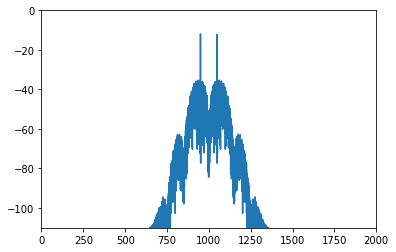

In [ ]:
plt.figure()
N = st.shape[0]
Y1 = fft(st)/N
frq1 = fftfreq(N, 1/fs)
plt.plot(frq1, 20*np.log10(abs(Y1)))
plt.xlim(0,2000)
plt.ylim(-110,0)
plt.show()

------------------------------------------------------------------------------------------------

## Segunda parte - fase como entrada

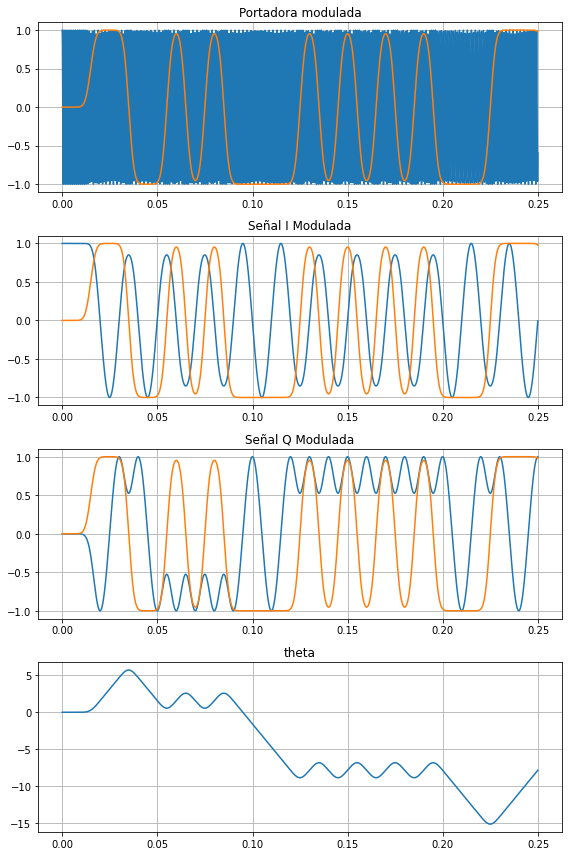

In [ ]:
# Señales Modulantes
#theta = (t*ts)*2*np.pi*DeltaF
#theta = theta*(Señal_Tx)

# Integracion
theta = []
theta_acumulada = 0
for i_señal_tx in Señal_Tx:
    theta_acumulada += i_señal_tx*(ts)*(2*np.pi)*DeltaF
    theta.append(theta_acumulada)
#theta = []
#theta_acumulada = 0
#for i in range(len(Señal_Tx)-1):
#    theta_acumulada += ( (Señal_Tx[i]*ts) + ((Señal_Tx[i+1]-Señal_Tx[i])*ts)/2 )*(2*np.pi)*DeltaF
#    theta.append(theta_acumulada)
#theta_acumulada += (Señal_Tx[-1]*ts)*(2*np.pi)*DeltaF
#theta.append(theta_acumulada)


Cos_theta = np.cos(theta)
Sin_theta = np.sin(theta)


# Portadoras
OL_Cos = np.cos(2*np.pi*(Fc)*(t*ts))
OL_Sin = np.sin(2*np.pi*(Fc)*(t*ts))


# Modulacion de las portadoras
I = Cos_theta
Q = -1 * Sin_theta
st  = OL_Cos*I + OL_Sin*Q


plt.figure(figsize=(8,12))
plt.subplot(411)
plt.plot(ts*t[0:Ns*25], st[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Portadora modulada")
plt.subplot(412)
plt.plot(ts*t[0:Ns*25], I[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal I Modulada")
plt.subplot(413)
plt.plot(ts*t[0:Ns*25], Q[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal Q Modulada")
plt.subplot(414)
plt.plot(ts*t[0:Ns*25], theta[0:Ns*25])
plt.grid()
plt.title("theta")
plt.tight_layout()
plt.show()

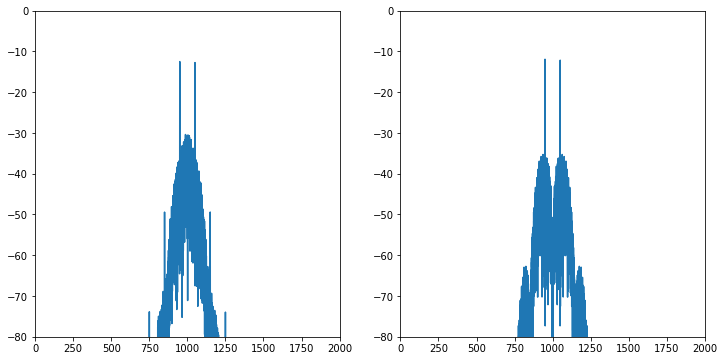

In [ ]:
plt.figure(figsize=(12,6))
N = st.shape[0]
Y = fft(st)/N
frq = fftfreq(N, 1/fs)
plt.subplot(121)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(0,2000)
plt.ylim(-80,0)
plt.subplot(122)
plt.plot(frq1, 20*np.log10(abs(Y1)))
plt.xlim(0,2000)
plt.ylim(-80,0)
plt.show()

------------------------------------------------------------------------------------------------